# Trigger Experiments

Here we try to look for event triggers that became false positives because our event annotation is based on n-ary relation annotation, even though they are not actually false positives.
In n-ary relation annotation a trigger was only annotated as part of a relation if there was atleast one more argument in the same sentence.

We also try to quantify the quality of labeling functions for event triggers that only rely on trigger lists vs. labeling functions that look at the nearest entity/ context words.

In [1]:
import sys
sys.path.append("../")

## Data preparation
We first load the SD4M gold train data, build the trigger examples and add some information to help us during the experiments

In [8]:
import pandas as pd
from wsee.utils import corpus_statistics

def display_corpus_stats(corpus_df):
    train_stat = corpus_statistics.get_snorkel_event_stats(corpus_df)
    general_stats = pd.DataFrame({x: train_stat[x] for x in train_stat if x not in ['Trigger class frequencies', 'Role class frequencies']}, index=[0])
    trigger_stats = pd.DataFrame(train_stat['Trigger class frequencies'], index=[0])
    role_stats = pd.DataFrame(train_stat['Role class frequencies'], index=[0])
    display(general_stats)
    display(trigger_stats)
    display(role_stats)

In [9]:
sd4m_train = pd.read_json("../data/daystream_corpus/train/train_with_events_and_defaults.jsonl", lines=True, encoding='utf8')
filtered_sd4m_train = sd4m_train[sd4m_train.apply(lambda document: corpus_statistics.has_triggers(document), axis=1)]
display_corpus_stats(filtered_sd4m_train)

,# Docs,# Docs with event triggers,# Event triggers with positive label,# Event triggers with negative label,# Event triggers with abstain,# Docs with event roles,# Event role with positive label,# Event roles with negative label,# Event roles with abstain
0,567,413,488,289,0,413,2001,5284,0


,Accident,CanceledRoute,CanceledStop,Delay,Obstruction,RailReplacementService,TrafficJam,O
0,59,61,25,65,101,22,155,289


,location,delay,direction,start_loc,end_loc,start_date,end_date,cause,jam_length,route,no_arg
0,571,87,277,377,352,35,41,103,135,23,5284


In [10]:
from wsee.data import pipeline

df_sd_train, Y_sd_train = pipeline.build_event_trigger_examples(filtered_sd4m_train)

INFO:wsee:Building event trigger examples
INFO:wsee:DataFrame has 567 rows
567it [00:00, 641.35it/s]
INFO:wsee:Number of events: 488
INFO:wsee:Number of event trigger examples: 777


In [11]:
from wsee.preprocessors import preprocessors

def get_simple_trigger(doc):
    trigger = doc.trigger
    simple_trigger = {
        'text': trigger['text'],
        'entity_type': trigger['entity_type'],
        'char_start': trigger['char_start'],
        'char_end': trigger['char_end']
    }
    return simple_trigger

def add_simple_columns(df):
    df['trigger_sm'] = df.apply(lambda doc: get_simple_trigger(doc), axis=1)
    df['closest_entity'] = df.apply(lambda doc: preprocessors.get_closest_entity_same_sentence(doc), axis=1)
    return df

In [12]:
from wsee import SD4M_RELATION_TYPES
pd.set_option('display.max_colwidth', None)
labeled_sd4m_triggers = df_sd_train.copy()
labeled_sd4m_triggers['label'] = Y_sd_train
labeled_sd4m_triggers['event_type'] = [SD4M_RELATION_TYPES[label_idx] for label_idx in Y_sd_train]
labeled_sd4m_triggers = add_simple_columns(labeled_sd4m_triggers)

## Strategies for the labeling functions
The most straightforward strategy is to build keyword lists (trigger lists) for each event type and check if the text of a potential trigger matches any of the keywords.
Another strategy is to look at the entity type of the physically/syntactically nearest entity to the trigger in the sentence.
There may be very typical context words.

We found that using trigger lists plus fuzzy string matching worked very well. We added some checks to ensure that we comply with the annotation guidelines (event cause does not constitute an event trigger). 
We mostly just checked for required arguments in addition to the trigger text matching.

### Entity type of the nearest entity to the trigger
Here we first look at entity type distributions of the nearest entity to the trigger for each event type and then compare the labeling functions.

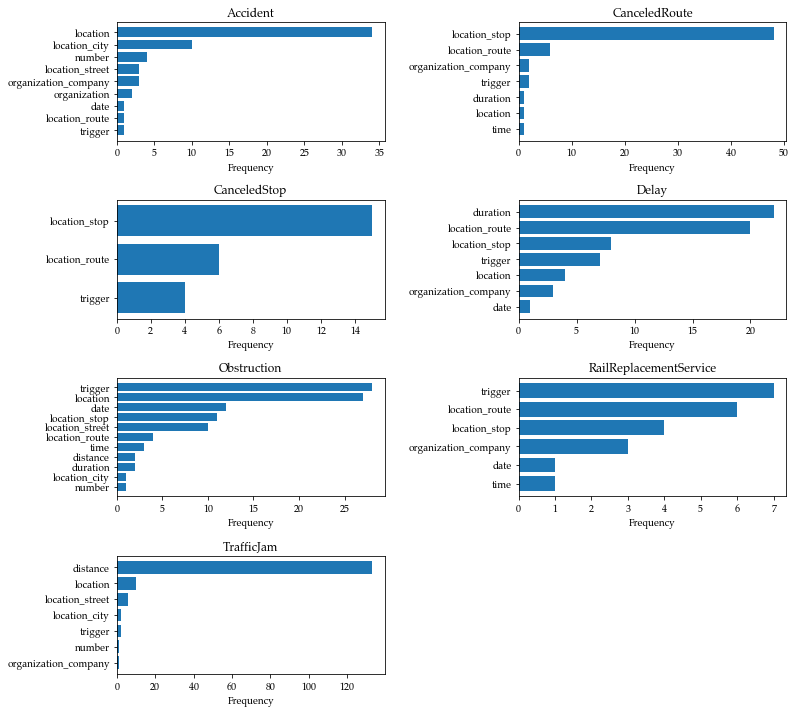

In [13]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "Palatino"
plt.rcParams['pdf.fonttype'] = 42

fig, ax = plt.subplots(4, 2, figsize=(12, 12))
# fig.suptitle('Top 3 Entity type frequencies of the closest entity to the trigger')
flat_axes = ax.flatten()
for label_idx, event_type in enumerate(SD4M_RELATION_TYPES[:-1]):
    rel_rows = labeled_sd4m_triggers[labeled_sd4m_triggers['label'] == label_idx]
    nearest_entity_types = [row['closest_entity']['entity_type'] for idx, row in rel_rows.iterrows() if row['closest_entity']]
    entity_types, counts = np.unique(nearest_entity_types, return_counts=True)
    count_sort_ind = np.argsort(-counts)
    entity_types = entity_types[count_sort_ind]
    counts = counts[count_sort_ind]
    y_pos = np.arange(len(entity_types))
    flat_axes[label_idx].barh(entity_types, counts, align='center')
    flat_axes[label_idx].invert_yaxis()  # labels read top-to-bottom
    flat_axes[label_idx].set_xlabel('Frequency')
    flat_axes[label_idx].set_title(event_type)
    plt.subplots_adjust(wspace=.5, hspace=.5)
fig.delaxes(ax[3,1])
plt.show()
fig.savefig("/Users/phuc/Documents/BA/Bachelorarbeit/img/Trigger-EntityTypes.pdf", bbox_inches = "tight")

We observed that the `duration` entity type was the most frequent entity type of the closest entity to `Delay` event triggers and the `distance` entity type was the most frequent entity type of the closest entity to  `TrafficJam` event triggers. While both `distance` and `duration` entities were sometimes observed as the entity type of the closest entity to the trigger for the `Obstruction` (2x `duration`, 2x `distance`) and `CanceledRoute` (1x `duration`) the much higher frequencies for `Delay` (> 20x `duration`) `TrafficJam` (> 120x `distance`) set them apart from the other event types.
This makes sense intuitively as a `duration` entity may be a `delay argument` to the `Delay` trigger and `distance` entity may be a `jam_length` argument to the `TrafficJam` trigger.

We did not observe similarly characteristic entity types of the closest entity to the triggers for the other event types.
`Accident` event triggers often co-occur with `location` entities, but so do `Obstruction` event triggers. 
`CanceledRoute` event triggers and `CanceledStop` event triggers often co-occur with `location_stop` entities.
`Obstruction` event triggers and `RailReplacementService` event triggers often co-occur with `trigger` entities.

Based on this observation we compare 2 strategies for labeling functions for `Delay` and `TrafficJam` event types.
1. Trigger list with fuzzy string matching (what we ended up using for the trigger labeling)
2. Entity type of closest entity to the trigger

In [7]:
from snorkel.labeling import labeling_function

Accident = 0
CanceledRoute = 1
CanceledStop = 2
Delay = 3
Obstruction = 4
RailReplacementService = 5
TrafficJam = 6
O = 7
ABSTAIN = -1


@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def accident_location_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'location':
        return Accident
    else:
        return ABSTAIN
    
@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def canceled_route_location_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'location_stop':
        return CanceledRoute
    else:
        return ABSTAIN
    
@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def canceled_stop_location_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'location_stop':
        return CanceledStop
    else:
        return ABSTAIN

@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def obstruction_trigger_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'trigger':
        return Obstruction
    else:
        return ABSTAIN
    
@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def rrs_trigger_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'trigger':
        return RailReplacementService
    else:
        return ABSTAIN
    
@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def delay_duration_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'duration':
        return Delay
    else:
        return ABSTAIN
    
@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def delay_duration_positional_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'duration' and x['closest_entity']['start'] < x['trigger']['start']:
        return Delay
    else:
        return ABSTAIN

@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def trafficjam_distance_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'distance':
        return TrafficJam
    else:
        return ABSTAIN
    
@labeling_function(pre=[preprocessors.pre_closest_entity_same_sentence])
def trafficjam_distance_positional_check(x):
    if x['closest_entity'] and x['closest_entity']['entity_type'] == 'distance' and x['closest_entity']['start'] < x['trigger']['start']:
        return TrafficJam
    else:
        return ABSTAIN

In [8]:
from wsee.labeling import event_trigger_lfs as trigger_lfs
from snorkel.labeling import PandasLFApplier

lfs = [
    accident_location_check,
    trigger_lfs.lf_accident_keywords, # trigger list + some checks for cause & parentheses
    canceled_route_location_check,
    trigger_lfs.lf_canceledroute_keywords,
    canceled_stop_location_check,
    trigger_lfs.lf_canceledstop_keywords,
    delay_duration_check,
    delay_duration_positional_check,
    trigger_lfs.lf_delay_keywords,  # trigger list + some checks for negation & parentheses
    obstruction_trigger_check,
    trigger_lfs.lf_obstruction_keywords,
    rrs_trigger_check,
    trigger_lfs.lf_railreplacementservice_keywords,
    trafficjam_distance_check,
    trafficjam_distance_positional_check,
    trigger_lfs.lf_trafficjam_keywords,  # trigger list + check for parentheses
] 
applier = PandasLFApplier(lfs)

In [9]:
L_sd_train = applier.apply(df_sd_train)

100%|██████████| 777/777 [00:17<00:00, 43.44it/s]


In [10]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L_sd_train, lfs).lf_summary(Y_sd_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
accident_location_check,0,[0],0.154440,0.091377,0.047619,34,86,0.283333
lf_accident,1,[0],0.084942,0.047619,0.003861,57,9,0.863636
canceled_route_location_check,2,[1],0.185328,0.185328,0.185328,48,96,0.333333
lf_canceledroute_cat,3,[1],0.088803,0.079794,0.079794,60,9,0.869565
canceled_stop_location_check,4,[2],0.185328,0.185328,0.185328,15,129,0.104167
lf_canceledstop_cat,5,[2],0.033462,0.025740,0.025740,25,1,0.961538
delay_duration_check,6,[3],0.033462,0.032175,0.002574,22,4,0.846154
delay_duration_positional_check,7,[3],0.028314,0.028314,0.001287,20,2,0.909091
lf_delay_cat,8,[3],0.083655,0.052767,0.024453,65,0,1.000000
obstruction_trigger_check,9,[4],0.141570,0.141570,0.141570,28,82,0.254545


The SD4M train set contains 65 `Delay`events and 155 `TrafficJam` events. Given that the trigger lists were refined using the SD4M training data, the recall is expectedly high.
The strategy of only checking whether the entity type of the closest entity to a potential `TrafficJam` trigger is `distance` worked fairly well with 133/155 recall and 133/137 precision.
It did not work as well for the `Delay` event type. While the precision of 22/26 was good, the recall of 22/65 is quite low. 
However both approaches did improve on the simpler, more straightforward strategy of matching the trigger text to trigger lists.

### Error analysis:

In [11]:
from wsee.labeling import error_analysis

In [12]:
error_analysis.get_false_positives(labeled_df=labeled_sd4m_triggers, lf_outputs=L_sd_train, lf_index=7, label_of_interest=3)[['text', 'trigger', 'closest_entity', 'event_type']]  # Delay - duration

,text,trigger,closest_entity,event_type
26,Vier Wochen Bus statt Bahn: Bauarbeiten an den Gleisen der Saalbahn zwischen Orlamünde und Saalfeld https://t.co/uzSDntGckm\n,"{'id': 'c/e1d11faf-99a0-4271-9200-1e13d4ab6653', 'text': 'Bauarbeiten', 'entity_type': 'trigger', 'start': 6, 'end': 7, 'char_start': 28, 'char_end': 39}","{'id': 'c/cec8c316-f0b5-4825-a788-f21172061d38', 'text': 'Vier Wochen', 'entity_type': 'duration', 'start': 0, 'end': 2, 'char_start': 0, 'char_end': 11}",Obstruction
1156,Die A4 Köln Richtung Aachen ist zwischen Kreuz Aachen und Grenzübergang Vetschau nach einem Unfall in den Niederlanden voraussichtlich noch mehrere Stunden gesperrt. Zurzeit 10km Stau. Sie sollten großräumig umfahren.\n,"{'id': 'c/a9687f89-d922-448f-9270-d9eca79a1b6d', 'text': 'gesperrt', 'entity_type': 'trigger', 'start': 22, 'end': 23, 'char_start': 156, 'char_end': 164}","{'id': 'c/f85b8f6c-2217-416a-8cc3-7f3195794e14', 'text': 'mehrere Stunden', 'entity_type': 'duration', 'start': 20, 'end': 22, 'char_start': 140, 'char_end': 155}",Obstruction


In [13]:
error_analysis.get_false_positives(labeled_df=labeled_sd4m_triggers, lf_outputs=L_sd_train, lf_index=5, label_of_interest=2)[['text', 'trigger', 'closest_entity', 'event_type']]  # TrafficJam - distance

,text,trigger,closest_entity,event_type
224,"am Freitag, 26. und Samstag, 27. Februar, jeweils 13.55 – 18.15 Uhr<br />\n<br />\nMeldung:<br />\nIC 2083 von Hamburg-Altona (planmäßige Ankunft 16.55 Uhr in Berchtesgaden Hbf) wird umgeleitet und hält nicht in München Ost. Aufgrund der Umleitung verspätet sich der Zug bis Freilassing um bis zu 20 Min. Von Freilassing bis Berchtesgaden Hbf wird der Zug durch einen Bus ersetzt.<br />\n<br />Grund:<br />\nOberleitungsarbeiten München – Rosenheim<br />\n<br />Link zur detaillierten Meldung: <br />\n<a href= / ><br />\nLink zum kompletten PDF-Dokument: <br />\n<a href=target=_blank>(91 kB)<br /><br />------------------<br /><br />\n","{'id': 'c/dee71cac-cc5a-43c7-bb30-7eb0e5ae9c95', 'text': 'nicht', 'entity_type': 'trigger', 'start': 41, 'end': 42, 'char_start': 200, 'char_end': 205}","{'id': 'c/f246dc08-dac3-4999-a953-a1bd2a25297f', 'text': 'hält', 'entity_type': 'trigger', 'start': 40, 'end': 41, 'char_start': 195, 'char_end': 199}",O


For both `Delay` & `duration` and `TrafficJam` & `distance` there were false positives, where the closest entity to the trigger was of the relevant entity type, but the trigger was of a different event type.

## Triggers that were not annotated as part of n-ary relation annotation
Here we manually examine a sample of 100 documents and count the number of event triggers and compare it the number of annotated event triggers (trigger argument from the n-ary relations).
According the annotation guidelines triggers should only be annotated if a relation is expressed in the sentence (ie. if you annotate a relation, also annotate triggers, if available). Furthermore only annotate one event in a sentence if one of the events is only mentioned as a cause and its occurence is not expressed explicitly.
E.g.: "wegen Notarzteinsatz gesperrt" - only annotate "gesperrt"

Alternative: compare labeling functions that check for required arguments vs. labeling functions that do not

In [14]:
sample_docs = pd.read_json("../data/daystream_corpus/train_sample.jsonl", lines=True, encoding='utf8')

In [15]:
display_corpus_stats(sample_docs)

{'# Docs': 100,
 '# Docs with event triggers': 71,
 '# Event triggers with positive label': 81,
 '# Event triggers with negative label': 61,
 '# Event triggers with abstain': 0,
 'Trigger class frequencies': {'Accident': 6,
  'CanceledRoute': 15,
  'CanceledStop': 3,
  'Delay': 16,
  'Obstruction': 14,
  'RailReplacementService': 5,
  'TrafficJam': 22,
  'O': 61},
 '# Docs with event roles': 71,
 '# Event role with positive label': 334,
 '# Event roles with negative label': 1294,
 '# Event roles with abstain': 0,
 'Role class frequencies': {'location': 87,
  'delay': 16,
  'direction': 42,
  'start_loc': 71,
  'end_loc': 63,
  'start_date': 8,
  'end_date': 8,
  'cause': 18,
  'jam_length': 19,
  'route': 2,
  'no_arg': 1294}}

In [16]:
from wsee import SD4M_RELATION_TYPES
import numpy as np

def get_simple_entities(x):
    simple_entities = []
    sorted_entities = sorted(x['entities'], key=lambda k: k['start'])
    for entity in sorted_entities:
        simple_entity = {
            'text': entity['text'],
            'entity_type': entity['entity_type'],
            'start': entity['start'],
            'end': entity['end']
        }
        simple_entities.append(simple_entity)
    return simple_entities

def get_simple_triggers(x):
    simple_triggers = []
    for trigger in x['event_triggers']:
        entity = preprocessors.get_entity(trigger['id'], x['entities'])
        simple_trigger = {
            'text': entity['text'],
            'entity_type': entity['entity_type'],
            'start': entity['start'],
            'end': entity['end'],
            'event_type': SD4M_RELATION_TYPES[np.argmax(trigger['event_type_probs'])]
        }
        simple_triggers.append(simple_trigger)
    return simple_triggers

def add_simple_columns2(df):
    df['simple_entities'] = df.apply(lambda doc: get_simple_entities(doc), axis=1)
    df['simple_triggers'] = df.apply(lambda doc: get_simple_triggers(doc), axis=1)
    return df

In [17]:
sample_docs = add_simple_columns2(sample_docs)

In [18]:
sample_docs.iloc[[65, 67, 79, 85, 91, 94]][['text', 'simple_entities', 'simple_triggers']]

,text,simple_entities,simple_triggers
65,A14 Magdeburg Richtung Halle zwischen Löbejün und Halle-Tornau stockender Verkehr an einer 10 km Stau an einer Baustelle\n,"[{'text': 'A14', 'entity_type': 'location_street', 'start': 0, 'end': 1}, {'text': 'Magdeburg', 'entity_type': 'location_city', 'start': 1, 'end': 2}, {'text': 'Halle', 'entity_type': 'location_city', 'start': 3, 'end': 4}, {'text': 'Löbejün', 'entity_type': 'location', 'start': 5, 'end': 6}, {'text': 'Halle-Tornau', 'entity_type': 'location', 'start': 7, 'end': 10}, {'text': 'stockender Verkehr', 'entity_type': 'trigger', 'start': 10, 'end': 12}, {'text': '10 km', 'entity_type': 'distance', 'start': 14, 'end': 16}, {'text': 'Stau', 'entity_type': 'trigger', 'start': 16, 'end': 17}]","[{'text': 'stockender Verkehr', 'entity_type': 'trigger', 'start': 10, 'end': 12, 'event_type': 'TrafficJam'}, {'text': 'Stau', 'entity_type': 'trigger', 'start': 16, 'end': 17, 'event_type': 'O'}]"
67,"A8 Karlsruhe Richtung Stuttgart zwischen Rutesheim und Leonberg-West ein defekter LKW, die rechte Spur ist gesperrt, 2 km Stau\n","[{'text': 'A8', 'entity_type': 'location_street', 'start': 0, 'end': 1}, {'text': 'Karlsruhe', 'entity_type': 'location_city', 'start': 1, 'end': 2}, {'text': 'Stuttgart', 'entity_type': 'location_city', 'start': 3, 'end': 4}, {'text': 'Rutesheim', 'entity_type': 'location', 'start': 5, 'end': 6}, {'text': 'Leonberg-West', 'entity_type': 'location', 'start': 7, 'end': 10}, {'text': 'gesperrt', 'entity_type': 'trigger', 'start': 18, 'end': 19}, {'text': '2 km', 'entity_type': 'distance', 'start': 20, 'end': 22}, {'text': 'Stau', 'entity_type': 'trigger', 'start': 22, 'end': 23}]","[{'text': 'gesperrt', 'entity_type': 'trigger', 'start': 18, 'end': 19, 'event_type': 'O'}, {'text': 'Stau', 'entity_type': 'trigger', 'start': 22, 'end': 23, 'event_type': 'TrafficJam'}]"
79,Vier Wochen Bus statt Bahn: Bauarbeiten an den Gleisen der Saalbahn zwischen Orlamünde und Saalfeld https://t.co/uzSDntGckm\n,"[{'text': 'Vier Wochen', 'entity_type': 'duration', 'start': 0, 'end': 2}, {'text': 'Bauarbeiten', 'entity_type': 'trigger', 'start': 6, 'end': 7}, {'text': 'Saalbahn', 'entity_type': 'location_route', 'start': 11, 'end': 12}, {'text': 'Orlamünde', 'entity_type': 'location_stop', 'start': 13, 'end': 14}, {'text': 'Saalfeld', 'entity_type': 'location_stop', 'start': 15, 'end': 16}]","[{'text': 'Bauarbeiten', 'entity_type': 'trigger', 'start': 6, 'end': 7, 'event_type': 'Obstruction'}]"
85,"von Sonntag, 8. Mai, 20.00 Uhr bis Samstag, 28. Mai, 5.45 Uhr\nMeldung:\nMehrere Nachtzüge werden zwischen Hamburg-Harburg und Hannover Hbf umgeleitet und verspäten sich um bis zu 25 Min. Der Halt in Lüneburg fällt aus.\nGrund:\nSchwellenauswechslung zwischen Hannover Hbf und Celle\nLink zur detaillierten Meldung: \nLink zum kompletten PDF-Dokument: \n(236 kB)\n------------------\n","[{'text': 'Sonntag, 8. Mai', 'entity_type': 'date', 'start': 1, 'end': 6}, {'text': '20.00 Uhr', 'entity_type': 'time', 'start': 7, 'end': 9}, {'text': 'Samstag, 28. Mai', 'entity_type': 'date', 'start': 10, 'end': 15}, {'text': '5.45 Uhr', 'entity_type': 'time', 'start': 16, 'end': 18}, {'text': 'Nachtzüge', 'entity_type': 'location_route', 'start': 21, 'end': 22}, {'text': 'Hamburg-Harburg', 'entity_type': 'location_stop', 'start': 24, 'end': 27}, {'text': 'Hannover Hbf', 'entity_type': 'location_stop', 'start': 28, 'end': 30}, {'text': 'verspäten', 'entity_type': 'trigger', 'start': 32, 'end': 33}, {'text': '25 Min', 'entity_type': 'duration', 'start': 37, 'end': 39}, {'text': 'Lüneburg', 'entity_type': 'location_stop', 'start': 43, 'end': 44}, {'text': 'Hannover Hbf', 'entity_type': 'location_stop', 'start': 51, 'end': 53}, {'text': 'Celle', 'entity_type': 'location_stop', 'start': 54, 'end': 55}, {'text': '236', 'entity_type': 'number', 'start': 68, 'end': 69}]","[{'text': 'verspäten', 'entity_type': 'trigger', 'start': 32, 'end': 33, 'event_type': 'Delay'}]"
91,#RE4 wird ab #Düsseldorf Hbf (17:26) b

In 5 document batches
"fällt" "aus": both as trigger, but only the former as event trigger

Without regard for relations/additional arguments vs. Annotation:

Triggers:  6, 7, 10, 6, 10, 9, 8, 6, 6, 10, 6, 16, 8, 9, 11, 6, 9, 6, 7, 4  vs. 5, 6, 8, 5, 8, 9, 8, 6, 6, 9, 4, 15, 7, 8, 9, 5, 9, 5, 6, 4

Event triggers:  4, 5, 5, 4, 7, 7, 3, 4, 4, 5, 5, 9, 6, 8, 7, 4, 4, 4, 4, 3 vs. 3, 4, 3, 3, 5, 7, 3, 4, 4, 6, 3, 8, 5, 5, 4, 3, 4, 3, 2, 3

Relevant instances:

1: (CanceledRoute with no location argument, trigger not annotated, edge case)
> Hildesheim Von Morgen bis einschliesslich Freitag wird der Stadtverkehr Hildesheim von Betriebsbeginn bis Betriebsende durch ver.di bestreikt, dadurch wird der gesamte Busverkehr eingestellt.

8: (Obstruction "Umleitung" with no location argument, trigger not annotated)
> Die A31 Bottrop Richtung Gronau ist zwischen Lembeck und Reken wegen Bergungsarbeiten gesperrt. Eine Umleitung führt ab Lembeck über die U25 

11: (RRS "Ersatz fahren Busse" with no location argument, trigger not annotated)
> Folgende Meldung ergänzt
> von Sonntag, 5. Juni, 13.55 Uhr bis Montag, 20. Juni, 12.00 Uhr
> Meldung: 
> Die IC-Züge fallen zwischen Augsburg Hbf und Oberstdorf aus.
> Die IC-Züge enden / beginnen in München-Pasing und fallen zwischen München-Pasing und Berchtesgaden Hbf aus.
> Als Ersatz fahren Busse zwischen Freilassing und Berchtesgaden Hbf.
> Grund:
> Gleiserneuerung 

12: (Obstruction event "nur ein Fahrstreifen frei" with no location argument, trigger not annotated)
> A40 Venlo Richtung Duisburg zwischen Wachtendonk und Kerken 5 km Stau. Dort ist wegen Bergungsarbeiten nur ein Fahrstreifen frei. (Zeitverlust: mehr als eine Viertelstunde) 

18: (Obstruction "nur eine Spur frei" with no location argument, trigger not annotated)
> ■ #A1 #Bremen Richtung #Hamburg zwischen Horster Dreieck und #Stillhorn 9 km #Stau. Dort ist wegen #Bauarbeiten nur eine Spur frei. 

21: (RRS "Als Ersatz fahren jeweils Busse" with no location argument, trigger not annotated)
> von Donnerstag, 5. Mai, 14.00 Uhr bis Dienstag, 10. Mai, 11.30 Uhr
> Meldung:
> IC 2083 von Hamburg-Altona (planmäßige Ankunft 16.55 Uhr in Berchtesgaden Hbf) endet in München-Pasing und fällt von München-Pasing bis Berchtesgaden Hbf aus.
> IC 2082 nach Hamburg-Altona (planmäßig 8.28 Uhr ab Berchtesgaden Hbf) beginnt in München-Pasing und fällt von Berchtesgaden Hbf bis München-Pasing aus.
> Als Ersatz fahren jeweils Busse zwischen Freilassing und Berchtesgaden Hbf.
> Hinweise: 
> Die Fahrplantabelle finden Sie in diesem PDF-Dokument
> Grund:
> Oberleitungsarbeiten zwischen Grafing Bahnhof und Ostermünchen

23: (CanceledStop "Halt in Lüneburg fällt aus", trigger not annotated)
> von Dienstag, 12. Juli, 23.00 Uhr bis Samstag, 16. Juli, 1.00 Uhr
> Meldung:
> Mehrere Nachtzüge werden zwischen Hamburg-Harburg und Hannover Hbf umgeleitet und verspäten sich dadurch um bis zu 30 Min. Der Halt in Lüneburg fällt aus.
> Grund:
> Gleiserneuerung Celle – Eschede

48: (CanceledStop "Busse halten nicht in Berlin Ostbahnhof", trigger not annotated)
> an mehreren Terminen
> von Montag, 1. August, 22.10 Uhr bis Donnerstag, 4. August, 7.45 Uhr
> von Freitag, 18. November, 22.10 Uhr bis Montag, 28. November, 7.45 Uhr
> Meldung:
> Die EC-Züge werden zwischen Berlin Hbf und Frankfurt (Oder) durch Busse ersetzt. Die Busse halten nicht in Berlin Ostbahnhof. B eachten Sie die 61 – 67 Min. frühere Abfahrt / spätere Ankunft der Busse in Berlin Hbf.
> Hinweise: 
> Bitte beachten Sie, dass die Haltestellen des Schienenersatzverkehrs nicht immer direkt an den jeweiligen Bahnhöfen liegen.
> In den Bussen ist leider keine Fahrradbeförderung möglich, Kinderwagen und Rollstühle können nur eingeschränkt befördert werden.
> Die Fahrplantabelle finden Sie in diesem PDF-Dokument
> Grund:
> Brückenarbeiten in Friedrichshagen und Fürstenwalde

50: (Obstruction "Umleitung" with no location argument, trigger not annotated)
> Die A7 Hannover Richtung Hamburg ist zwischen Dreieck Walsrode und Bad Fallingbostel gesperrt, bitte folgen Sie den Schildern. Die Umleitung führt für den Nahverkehr ab dem Dreieck Walsrode über die U53, für den Fernverkehr in Richtung Hamburg ab Dreieck Walsrode über die A27 zum Bremer Kreuz weiter über die A1 bis Buchholzer Dreieck und dann über die A261 

52: (Obstruction "behindert", trigger not annotated, matter of definition)
> Hamburg: B431 Stresemannstraße stadtauswärts zwischen Kaltenkircher Platz und der B4 behindert eine Unfallstelle den Verkehr. 

59: (RRS "Schienenersatzverkehr" no location argument, trigger not annotated)
> am Samstag, 13. und Sonntag, 14. Februar, jeweils ganztägig
> Meldung:
> Die IC-Züge enden / beginnen in Bad Bentheim und fallen zwischen Bad Bentheim und Amsterdam Centraal aus. Bitte nutzen Sie den Schienenersatzverkehr in diesem Abschnitt.
> Grund:
> Bauarbeiten Hengelo – Almelo

61: (RRS "Ersatz" with no location argument, trigger not annotated)
> am Donnerstag, 24. März, 7.00 – 10.00 Uhr
> Meldung:
> EN 459 von Leipzig Hbf (planmäßige Ankunft 9.28 Uhr in Praha hl.n.) fällt von Dresden Hbf bis Děčín hl.n. aus. Als Ersatz nutzen Sie den Bus von Dresden Hbf (ab 7.14 Uhr) bis Ústí nad Labem (an 8.20 Uhr). In Ústí nad Labem besteht Anschluss an einen Ersatzzug nach Praha hl.n.
> Grund:
> Oberleitungsarbeiten zwischen Bad Schandau und Königstein (Sächs Schw)

65: (double TrafficJam)
> A14 Magdeburg Richtung Halle zwischen Löbejün und Halle-Tornau stockender Verkehr an einer 10 km Stau an einer Baustelle 

67: (Obstruction annotation missing, required arguments are there)
> A8 Karlsruhe Richtung Stuttgart zwischen Rutesheim und Leonberg-West ein defekter LKW, die rechte Spur ist *gesperrt*, 2 km Stau 

69: (Obstruction, trigger not annotated, according to mental sentence boundaries no location argument in same sentence?, edge case)
> A2 Dortmund Richtung Hannover zwischen Dortmund-Nordost und Dortmund-Lanstrop 2 km Stau Wegen Bauarbeiten ist nur ein Fahrstreifen frei. 

71: (Accident as cause)
> Vollsperrung der #A100 in Fahrtrichtung Nord, Grund: schwerer Unfall

72: (CanceledStop, trigger not annotated) "kein Halt in Hamburg Hbf und Hamburg Dammtor...", (CanceledRoute with no location argument, trigger not annotated) "...Zugausfall Hamburg-Harburg > Hamburg-Altona..." 
> kein Halt in Hamburg Hbf und Hamburg Dammtor sowie zusätzlicher Halt in Hamburg-Bergedorf
> Zugausfall Hamburg-Harburg > Hamburg-Altona
> am Sonntag, 12. Juni, ganztägig
> Meldung:
> Mehrere IC-Züge halten nicht in Hamburg Hbf und Hamburg Dammtor. Einige Züge halten als Ersatz zusätzlich in Hamburg-Bergedorf.
> IC 2414 von Köln Hbf und 2276 von Karlsruhe Hbf (planmäßige Ankunft 19.01 Uhr und 21.43 Uhr in Hamburg-Altona) enden in Hamburg-Harburg und fallen von Hamburg-Harburg bis Hamburg-Altona aus.
> Grund:
> Brücken- und Weichenarbeiten in Hamburg Berliner Tor
 
79: (RailReplacementService with no location argument, trigger not annotated)
> Vier Wochen Bus statt Bahn: Bauarbeiten an den Gleisen der Saalbahn zwischen Orlamünde und Saalfeld 

85: (CanceledStop "Halt in Lüneburg fällt aus", trigger not annotated)
> von Sonntag, 8. Mai, 20.00 Uhr bis Samstag, 28. Mai, 5.45 Uhr
Meldung:
> Mehrere Nachtzüge werden zwischen Hamburg-Harburg und Hannover Hbf umgeleitet und verspäten sich um bis zu 25 Min. Der Halt in Lüneburg fällt aus.
> Grund:
> Schwellenauswechslung zwischen Hannover Hbf und Celle 

91: (Delay with no location argument, trigger not annotated)
> \#RE4 wird ab #Düsseldorf Hbf (17:26) bis #Mönchengladbach (17:48) ohne Halt umgeleitet.Mit 20 Minuten Verspätung muss in MG gerechnet werden

94: (Accident as cause)
> A7 Hannover Richtung Kassel zwischen Lutterberg und Kreuz Kassel-Mitte 4 km Stau nach einem Unfall

    
Sum

- 142 triggers in annotation vs. 160 manually determined triggers
- 81 event triggers in annotation vs. 103 manually determined event triggers
    - 13 had no required location argument
    - 2 causes
    - 1 multiple occurrence
    - 4 (3 CanceledStops, 1 Obstruction) were missed 
    - 2 edge cases for Obstruction, 1 edge case for CanceledRoute 
- 4 cases where a trigger entity was annotated, 18 cases where the trigger entity itself was not annotated
